# Initialisations

In [1]:
import numpy
import matplotlib.pyplot as plt
import random
import math

In [2]:
SIGMA = 1
EPSILON = 1
A = 2
X_0 = 1
KT = 1
MAX_D = SIGMA / 2

N = 36

DIM = 2

SHAPE = (N, DIM)

BOX_L = 6

N_DIMER = 2

particles = numpy.random.uniform(BOX_L / 4, 3 * BOX_L / 4, SHAPE)


dimer_list = [[0, 0], [0, 0]]
# initially second particle in dimer is kept close to first
for i in range(DIM):
    dimer_list[0][i] = numpy.random.uniform(BOX_L / 4, 3 * BOX_L / 4)
    dimer_list[1][i] = dimer_list[0][i] + numpy.random.uniform(0.1, 0.3)

dimer = numpy.array(dimer_list)

## Potential related functions

In [3]:
def pbc_dist(pox_x, pos_y):
    r = pox_x - pos_y
    for i in range(DIM):
        r[i] -= round(r[i] / BOX_L) * BOX_L

    return numpy.linalg.norm(r)


def lj_pair_potential(pos_x, pos_y):
    r = pbc_dist(pos_x, pos_y)
    if r == 0:
        return 0

    sigma_by_r = SIGMA / r
    return 4 * EPSILON * (sigma_by_r**12 - sigma_by_r**6)


def lj_potential_at_pos(pos_i):
    if pos_i >= N:
        pos = dimer[pos_i - N]
    else:
        pos = particles[pos_i]

    ret = 0
    for i, d in enumerate(particles):
        if pos_i == i:
            continue

        ret += lj_pair_potential(pos, d)

    pos_i -= N
    for i, d in enumerate(dimer):
        if pos_i == i:
            continue

        ret += lj_pair_potential(pos, d)

    return ret


def dimer_dist():
    return pbc_dist(dimer[1], dimer[0])


def dimer_potential():
    return A * (dimer_dist() ** 2 - X_0**2) ** 2


def lj_total_potential():
    total = dimer_potential()
    for i in range(len(particles) + 2):
        total += lj_potential_at_pos(i)

    return total / 2


## Monte carlo related functions

In [4]:
MONTE_CARLO_STEPS = 5000
ROUND_DIST = 3

CONFIG_STORES = 10
CONFIG_STORE_STRIDE = MONTE_CARLO_STEPS / CONFIG_STORES

def p_acc(del_e):
    expo = -1 * (1 / KT) * del_e
    if expo >= 0:
        return 1

    return math.exp(expo)

def random_move_pos(pos):
    for j in range(DIM):
        pos[j] += random.uniform(-MAX_D, MAX_D)
        if pos[j] >= BOX_L:
            pos[j] -= BOX_L
        
        if pos[j] < 0:
            pos[j] += BOX_L


def monte_carlo_step():
    i = random.randrange(N + 2)

    old_potential = lj_potential_at_pos(i)
    if i < N:
        old_save = numpy.copy(particles[i])
        random_move_pos(particles[i])
        del_energy = lj_potential_at_pos(i) - old_potential
    else:
        old_save = numpy.copy(dimer[i - N])
        old_potential += dimer_potential()
        random_move_pos(dimer[i - N])
        del_energy = lj_potential_at_pos(i) + dimer_potential() - old_potential

    if random.random() < p_acc(del_energy):
        return del_energy

    if i < N:
        particles[i] = old_save
    else:
        dimer[i - N] = old_save

    return 0


def monte_carlo():
    pe = lj_total_potential()
    d_dists = {}
    energies = []
    configs = []
    for i in range(MONTE_CARLO_STEPS):
        pe += monte_carlo_step()
        energies.append(pe)
        d_dist = round(dimer_dist(), ROUND_DIST)
        try:
            d_dists[d_dist] += 1
        except KeyError:
            d_dists[d_dist] = 1
        
        if i % CONFIG_STORE_STRIDE == 0:
            configs.append((particles.copy(), dimer.copy()))


    return d_dists, energies, configs


data, energies, configs = monte_carlo()




## The required plot (p(x) vs x)

Text(0.5, 1.0, 'p(x) vs x')

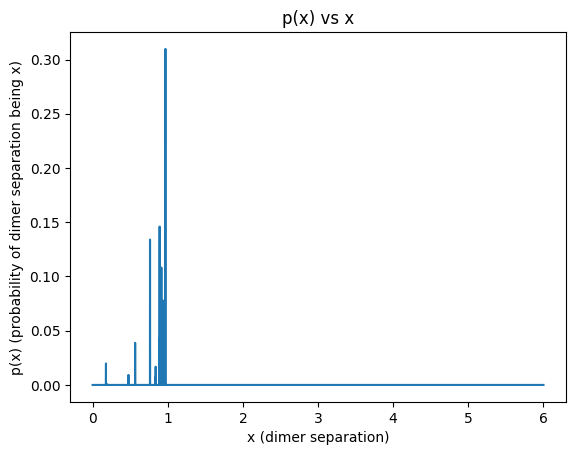

In [5]:
def p(x):
    try:
        return data[round(x, ROUND_DIST)] / MONTE_CARLO_STEPS
    except KeyError:
        return 0
    
plot_data = numpy.array([(x, p(x)) for x in numpy.linspace(0, BOX_L, 20000)])
plt.plot(plot_data[:,0], plot_data[:,1])
plt.xlabel("x (dimer separation)")
plt.ylabel("p(x) (probability of dimer separation being x)")
plt.title("p(x) vs x")

We observe that the plot is randomly situated around a peak, and the peak in this curve is at around $x = 1$. This is because $x_0 = 1$ in our dimer potential so this is the most stable distance of separation in the dimer.

However, it can happen that for some cases the peak is not at 1, and is higher. This happens if other particles randomly come in between the two particles in the dimer

## Additional plots for sanity checks and self-verification

Text(0.5, 1.0, 'P.E vs i')

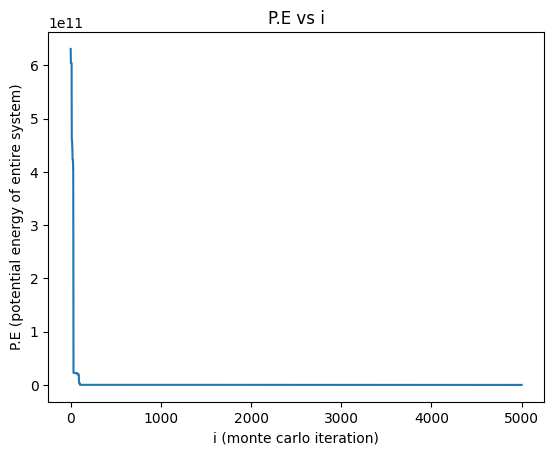

In [6]:
plt.plot(energies)
plt.xlabel("i (monte carlo iteration)")
plt.ylabel("P.E (potential energy of entire system)")
plt.title("P.E vs i")

As expected, initial potential is very high and then it immediately falls drastically.

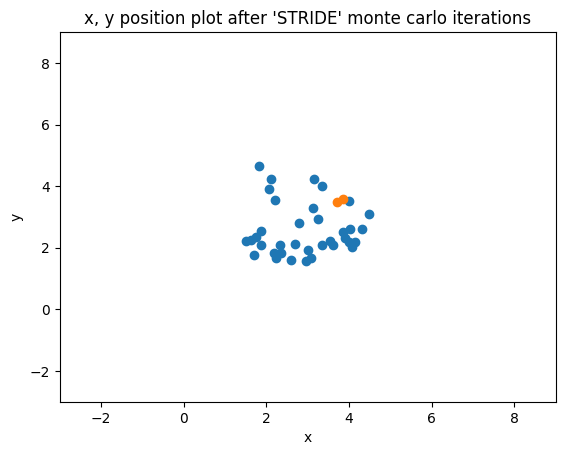

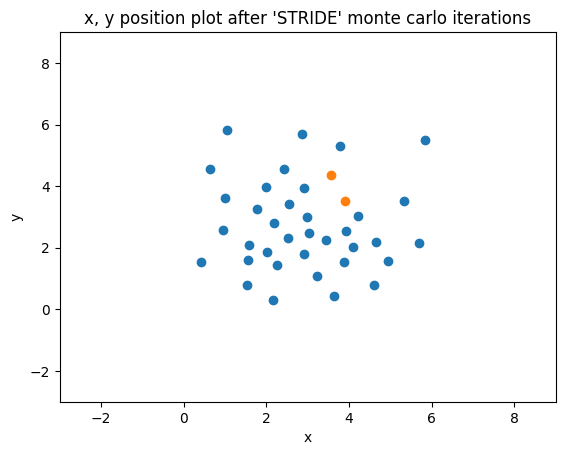

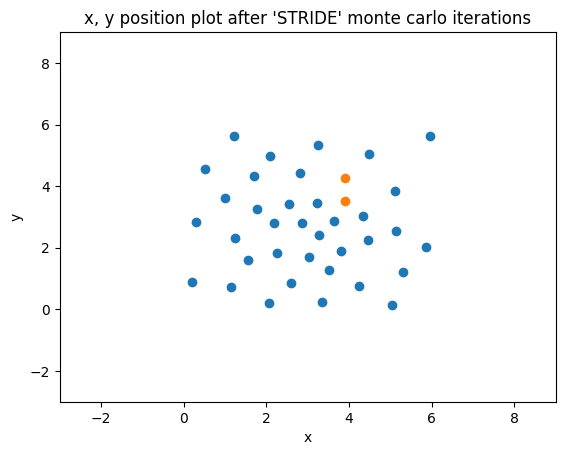

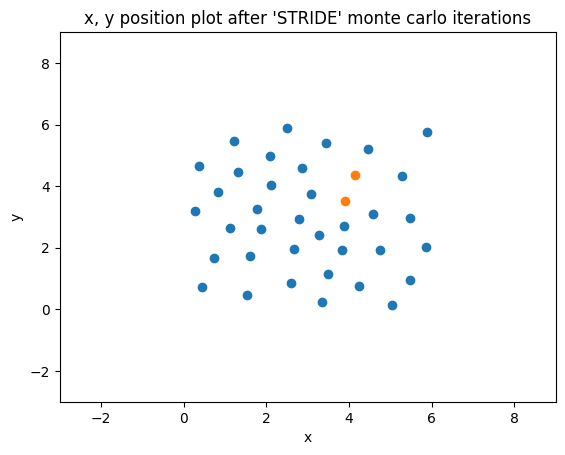

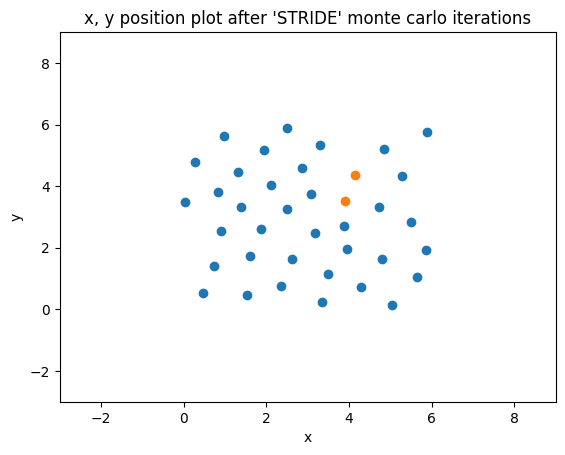

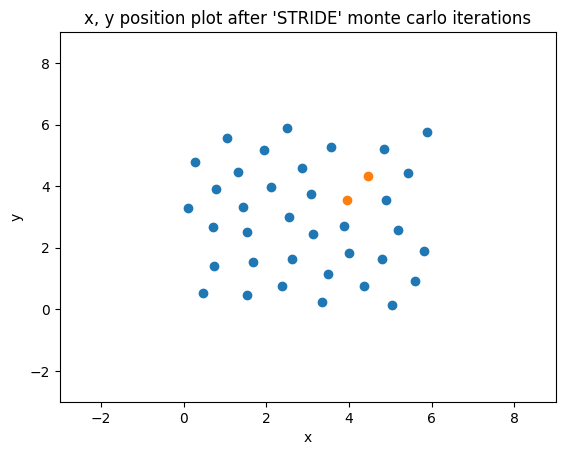

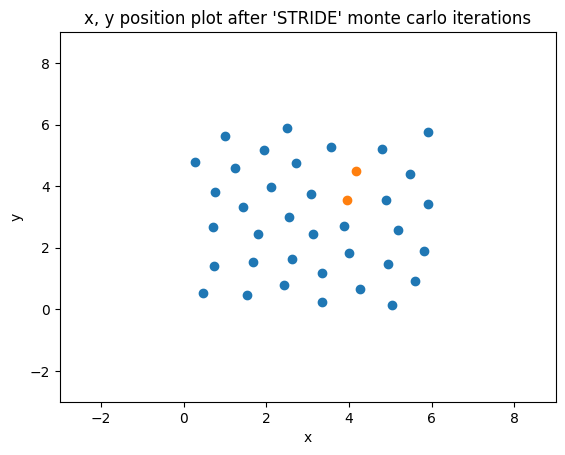

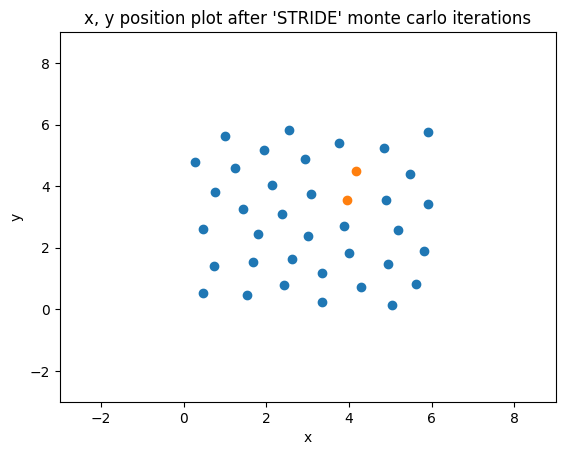

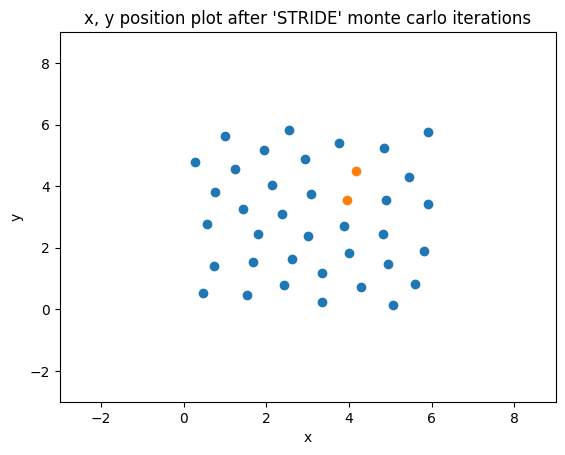

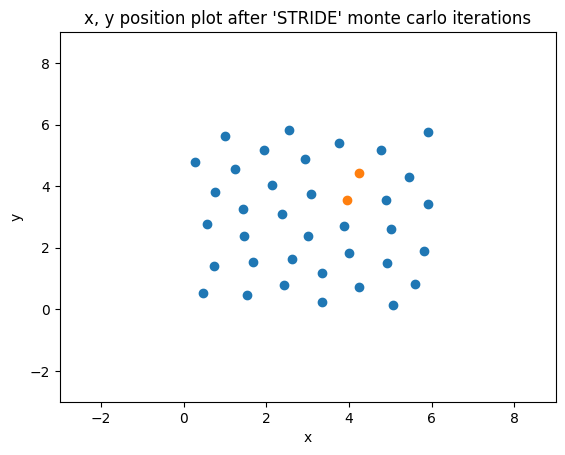

In [7]:
def plot_config(config):
    particles, dimer = config
    plt.scatter(particles[:,0], particles[:,1])
    plt.scatter(dimer[:,0], dimer[:,1])
    lim = BOX_L / 2
    plt.xlim(-lim, 3 * lim)
    plt.ylim(-lim, 3 * lim)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("x, y position plot after 'STRIDE' monte carlo iterations")
    plt.show()

for c in configs:
    plot_config(c)